# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [1]:
# import libraries here; add more as necessary
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp
import lightgbm as lgb
from skopt import BayesSearchCV

sys.path += ['./ilikeds']
import eda 
import helper_functions as h
import train_classifier as t
# magic word for producing visualizations in notebook

import warnings                             
warnings.filterwarnings('ignore')
%matplotlib inline

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。

你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_pickle ('../data/azdias.p')    
customers = pd.read_pickle ('../data/customers.p')    

In [3]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
feat_info.set_index('feat', inplace =True)

In [4]:
# 创建德国一般人口统计数据集 (azidas)的 EDA 对象
eda_azdias= eda.EDA(azdias, feat_info, label = 'Azdias')
# 邮购公司顾客人口统计数据集 (customers)的 EDA 对象
eda_customers= eda.EDA(customers, feat_info, label = 'Customers')

### 数据整理

#### Step 1: 删除未定义特征

In [5]:
feats_todrop = []
feats_wo_def = list(set(eda_azdias.data.columns) - set(eda_azdias.feat_info.index))

eda_azdias.data.drop(columns = feats_wo_def, inplace =True)
eda_customers.data.drop(columns = feats_wo_def, inplace =True)

In [6]:
feats_customers_excl  = list(set(eda_customers.data.columns) - set(eda_azdias.data.columns))
feats_customers_excl
eda_customers.data.drop(columns = feats_customers_excl, inplace =True)

####  Step 2: 转换缺失和未知数据

In [7]:
eda_azdias.missing2nan()
eda_customers.missing2nan()

Number of missing values in Azdias:
Before converstion is 28909421
Ater converstion IS 80037210
Increase in missing values: 176.86 % 
Number of missing values in Customers:
Before converstion is 12553501
Ater converstion IS 22936825
Increase in missing values: 82.71 % 


####  Step 3: 删除空值较多的样本（行）

(array([3.4000e+01, 1.9300e+02, 7.5700e+02, 2.9700e+03, 4.6420e+03,
        7.6070e+03, 1.6657e+04, 1.9227e+04, 2.6354e+04, 3.2940e+04,
        5.3739e+04, 4.4841e+04, 4.6389e+04, 6.2816e+04, 4.6531e+04,
        4.7817e+04, 4.9163e+04, 7.0863e+04, 8.7205e+04, 8.4759e+04,
        1.7085e+04, 1.3091e+04, 1.4340e+03, 2.9700e+02, 4.8900e+02,
        6.0200e+02, 9.4500e+02, 1.9340e+03, 2.1110e+03, 2.6730e+03,
        3.1240e+03, 4.4200e+03, 3.1900e+03, 3.3450e+03, 4.3140e+03,
        4.4640e+03, 5.1010e+03, 4.3640e+03, 3.5730e+03, 1.7320e+03,
        7.1300e+02, 7.0400e+02, 1.5100e+02, 8.7000e+01, 7.3000e+01,
        1.1800e+02, 1.0300e+02, 1.2000e+02, 2.7400e+02, 2.2200e+02,
        2.3200e+02, 4.1000e+02, 3.2900e+02, 4.2400e+02, 5.0600e+02,
        1.0410e+03, 1.3350e+03, 3.3500e+02, 2.0000e+02, 6.5000e+01,
        1.7000e+01, 2.3000e+01, 5.7000e+01, 8.0000e+01, 1.5500e+02,
        3.0000e+02, 3.2500e+02, 4.6800e+02, 5.5500e+02, 7.7400e+02,
        7.0500e+02, 7.1800e+02, 1.1940e+03, 1.10

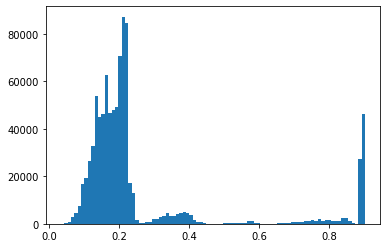

In [8]:
rows_n_nans = azdias.isnull().sum(axis=1)
plt.hist(rows_n_nans / azdias.shape[1], bins=90)

In [9]:
_, rows_droped = h.split_dataset(azdias, threshold=0.25)

print(f'清理缺失行前 azdias 有 {azdias.shape[0]} 行')
print(f'共删除 {rows_droped.shape[0]} 行')
azdias.drop(index = rows_droped.index, inplace =True)
print(f'清理缺失行后 azdias 有 {azdias.shape[0]} 行')

清理缺失行前 azdias 有 891221 行
共删除 154537 行
清理缺失行后 azdias 有 736684 行


In [10]:
_, rows_droped = h.split_dataset(customers, threshold=0.25)
n_droped_rows = rows_droped.shape[0]
print(f'清理缺失行前 customers 有 {customers.shape[0]} 行')
customers.drop(index = rows_droped.index, inplace =True)
print(f'清理缺失行后 customers 有 {customers.shape[0]} 行')
print(f'共删除 {n_droped_rows} 行')

清理缺失行前 customers 有 191652 行
清理缺失行后 customers 有 134251 行
共删除 57401 行


####  Step 4: 删除空值较多的特征（列）

Text(0.5, 1.0, 'Distribution of missing value per column')

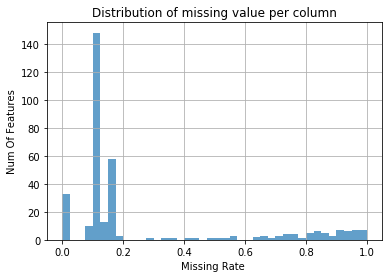

In [11]:
# 查看各特征缺失值的分布
eda_azdias.feat_info.percent_of_nans.sort_values().hist(bins = 40, alpha = 0.7)
plt.xlabel('Missing Rate ')
plt.ylabel('Num Of Features')
plt.title('Distribution of missing value per column')

In [12]:
thr_col_missing = 0.37
feats_todrop_azdias = eda_azdias.feat_info.loc[eda_azdias.feat_info.percent_of_nans > thr_col_missing].index
feats_todrop_azdias

Index(['AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_O

In [13]:
feats_todrop_customers = eda_customers.feat_info.loc[eda_customers.feat_info.percent_of_nans >thr_col_missing ].index
feats_todrop_customers

Index(['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
    

In [14]:
feats_todrop_comm = set(feats_todrop_customers).intersection(set(feats_todrop_azdias))
feats_todrop_comm = list(feats_todrop_comm)
feats_todrop_comm

['D19_WEIN_FEINKOST',
 'D19_BANKEN_ANZ_12',
 'D19_ENERGIE',
 'D19_REISEN',
 'D19_VERSI_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_TELKO_ANZ_24',
 'TITEL_KZ',
 'D19_LEBENSMITTEL',
 'D19_GARTEN',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_DATUM',
 'D19_TELKO_REST',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_TELKO_MOBILE',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_RATGEBER',
 'D19_LOTTO',
 'AGER_TYP',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_SCHUHE',
 'D19_FREIZEIT',
 'D19_DIGIT_SERV',
 'D19_BANKEN_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA05_BAUMAX',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_HAUS_DEKO',
 'D19_BANKEN_REST',
 'D19_BANKEN_DIREKT',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_TECHNIK',
 'GEBURTSJAHR',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_SONSTIGE',
 'D19_VERSICHERUNGEN',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_VERSI_ANZ_24',
 'D19_VOLLSORTIMENT',
 'D19_B

In [15]:
print(f'清理列缺失值')
print(f'清理前 {eda_azdias} 有  {eda_azdias.data.shape[1]} 列')
azdias.drop(columns=feats_todrop_comm, inplace=True)
print(f'清理后 {eda_azdias} 有  {eda_azdias.data.shape[1]} 列')

print(f'清理前 {eda_customers} 有  {eda_customers.data.shape[1]} 列')
customers.drop(columns=feats_todrop_comm, inplace=True)
print(f'清理后 {eda_customers} 有  {eda_customers.data.shape[1]} 列')

清理列缺失值
清理前 Azdias 有  340 列
清理后 Azdias 有  270 列
清理前 Customers 有  340 列
清理后 Customers 有  270 列


####  Step  5:  清理信息重复的特征（列）

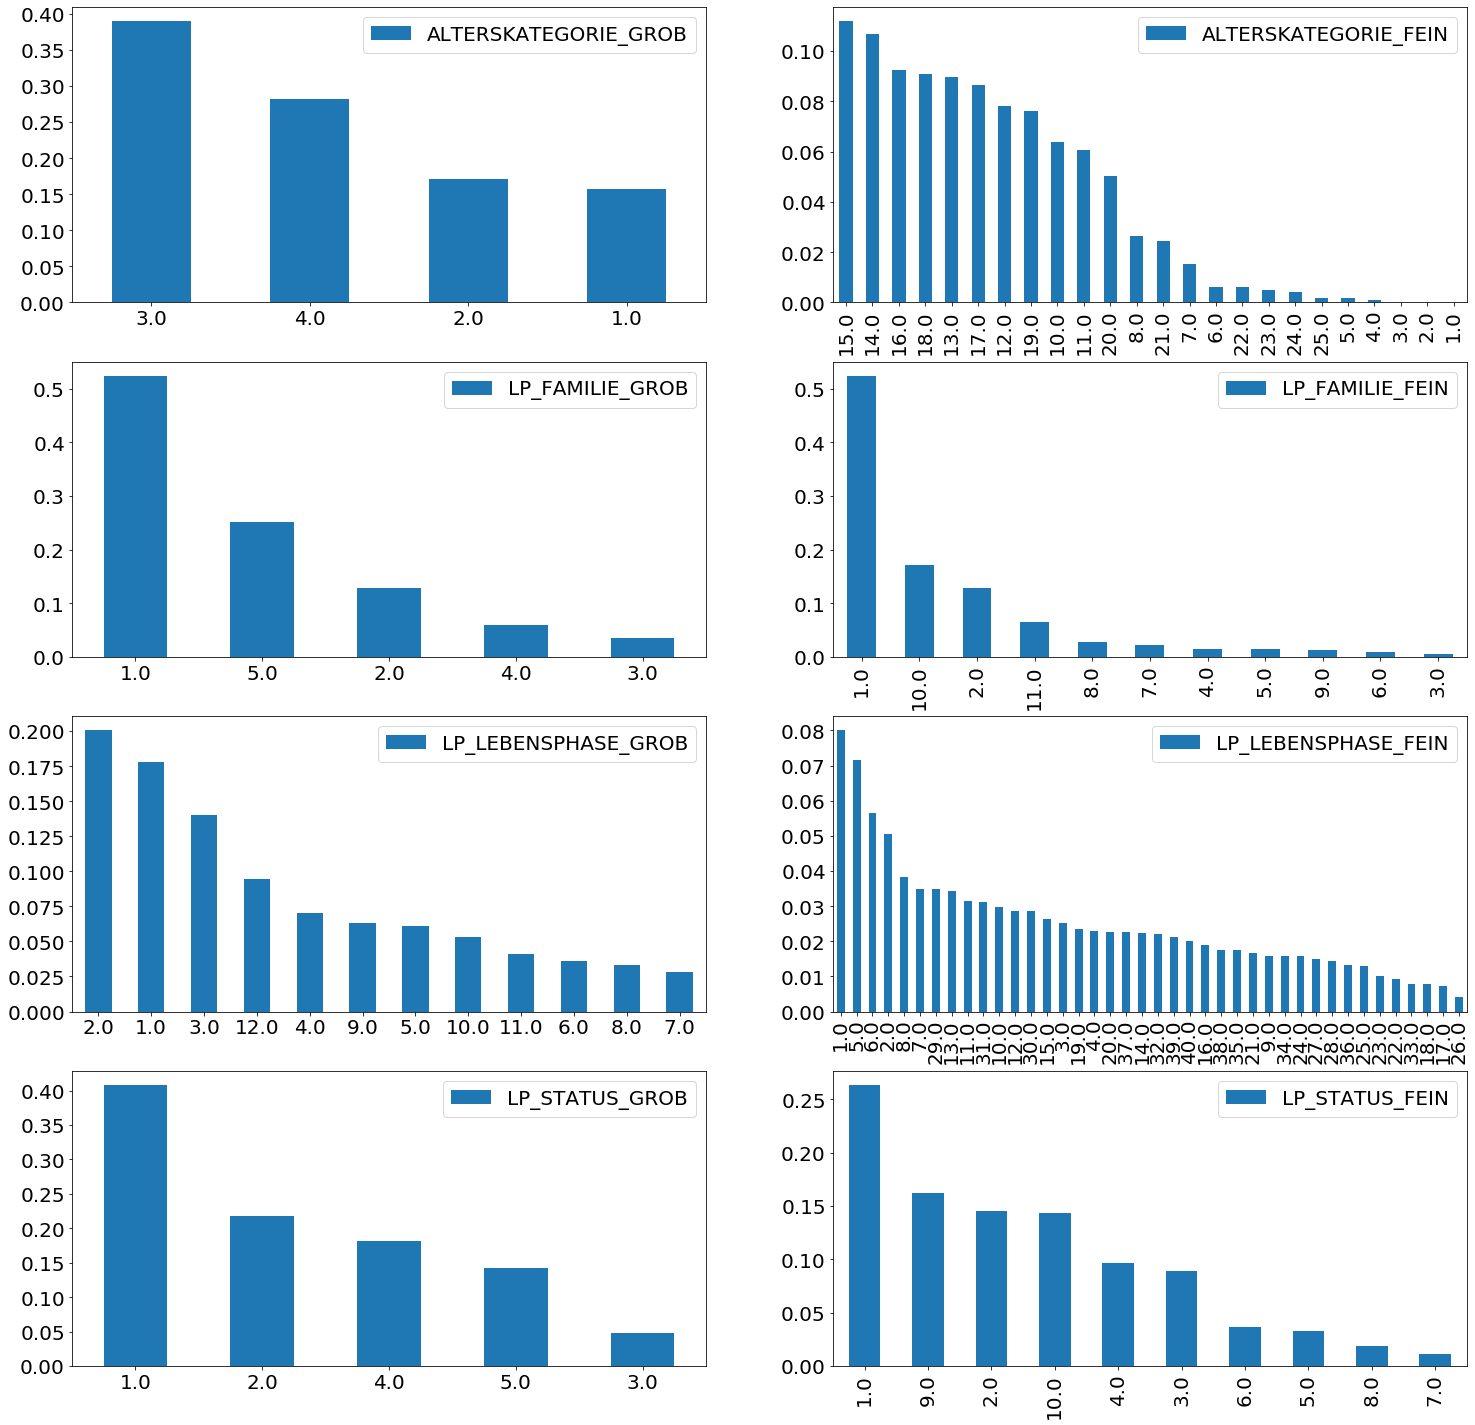

In [16]:
feats_fein =[x for x in eda_azdias.data.columns if x.endswith( '_FEIN')]
feats_grob = [x for x in eda_azdias.data.columns if x.endswith( '_GROB')]
feats_duplicate = [x for x in zip(pd.Series(feats_grob).sort_values(), pd.Series(feats_fein).sort_values())]
h.plot_2feats_comparison(eda_azdias.data, feats_duplicate)   

- 删除 ALTERSKATEGORIE_FEIN， 因为它是 ALTERSKATEGORIE_GROB 细粒度版本， 而且没有定义。
- 删除 LP_FAMILIE_GROB, 因为 LP_FAMILIE_FEIN 已经包含它的信息
- 删除 LP_LEBENSPHASE_GROB, 因为 LP_LEBENSPHASE_FEIN 已经包含它的信息
- 删除 LP_STATUS_GROB, 因为 LP_STATUS_FEIN 已经包含它的信息

In [17]:
feats_duplicated = ['ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB','CAMEO_DEU_2015']

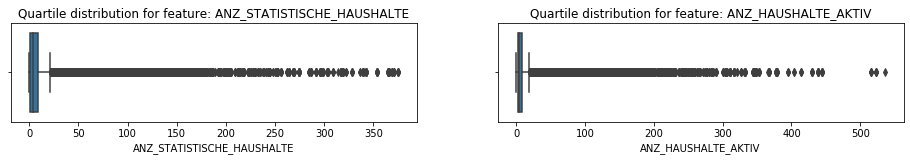

In [18]:
# ANZ_STATISTISCHE_HAUSHALTE, ANZ_HAUSHALTE_AKTIV :  number of households in the building
feats_HAUSHALTE = ['ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HAUSHALTE_AKTIV']
h.plot_boxplot(eda_azdias.data, feats_HAUSHALTE, n_cols =2,  figsize = (16, 4))     

- ANZ_STATISTISCHE_HAUSHALTE, ANZ_HAUSHALTE_AKTIV :  number of households in the building
- 删除 ANZ_STATISTISCHE_HAUSHALTE 因为其和 ANZ_HAUSHALTE_AKTIV 重复，并且没有定义

In [19]:
feats_duplicated.extend(['ANZ_STATISTISCHE_HAUSHALTE'])
azdias.drop(columns=feats_duplicated, inplace=True)
customers.drop(columns=feats_duplicated, inplace=True)

####  Step  6:  分析类别型特征

In [20]:
# how many categorical features do we have?
categorical = eda_azdias.feat_info[feat_info['type'] == 'categorical']
categorical.shape

(30, 4)

##### a. 查看类别型特征

In [21]:
h.check_features(eda_azdias, 'categorical')            

AGER_TYP was eliminated already
ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1']
CAMEO_DEU_2015 was eliminated already
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
D19_KONSUMTYP [nan  9.  1.  4.  3.  6.  5.  2.]
DSL_FLAG [1. 0.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
HH_DELTA_FLAG [ 0. nan  1.]
KK_KUNDENTYP was eliminated already
KONSUMZELLE [ 1.  0. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB was eliminated already
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  8.  5.  6.  7. nan]
LP_STATUS_GROB was eliminated already
NATIONALITAET_KZ [ 1.  3.  2. nan]
OST_WEST_KZ ['W' 'O']
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
TITEL_KZ was eliminated already
UNGLEICHENN_FLAG [1. 0.]
VERS_TYP [ 2.  1. nan]
ZABEOTYP [5 3 4 1 6 2]
D19_KONSUMTYP_MAX [9 8 1 2 4 3]
VHA was eliminated alr

##### b. 重编码部分类别型特征

 - 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015'  表示 “New German CAMEO Typology established together with Call Credit in late 2015”.
 - 'EINGEFUEGT_AM',  'OST_WEST_KZ'  也需要重新编码

In [22]:
feats_encoding = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']

for x in feats_encoding:
    eda_azdias.re_encoding(x)
    eda_customers.re_encoding(x)        

##### c. 拆分层次化类别型特征

以下特征是层次化特征：
1. CAMEO_INTL_2015 - CAMEO classification 2015 - international typology. 拆分为两个包含家庭分组和财富指标的新变量。
2. PRAEGENDE_JUGENDJAHRE - dominating movement in the person's youth (avantgarde or mainstream). 创建四个新的变量，包括年代，运动类型，运动是否前卫/主流的指示，位置O/W/O+W。
4. LP_LEBENSPHASE_GROB - life stage rough. 拆分为三个包含年龄、家庭和收入的新变量。

In [23]:
# eda_azdias.data.CAMEO_INTL_2015.astype('float64').value_counts()
# eda_customers.data.LP_LEBENSPHASE_GROB.value_counts()

In [24]:
mixed = eda_azdias.feat_info[feat_info['type'] == 'mixed']
mixed

,type,unknown,n_nans,percent_of_nans
feat,,,,
CAMEO_INTL_2015,mixed,"['-1','XX']",99352,0.11
LP_LEBENSPHASE_FEIN,mixed,[0],97632,0.11
LP_LEBENSPHASE_GROB,mixed,[0],94572,0.11
PRAEGENDE_JUGENDJAHRE,mixed,"[-1,0]",108164,0.12


In [25]:
h.check_features(eda_azdias, 'mixed')

CAMEO_INTL_2015 [51. 24. 12. 43. 54. 22. 14. 13. 15. 41. 34. 55. 33. 25. nan 23. 31. 52.
 45. 35. 44. 32.]
LP_LEBENSPHASE_FEIN was eliminated already
LP_LEBENSPHASE_GROB [ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  8.  4.]
PRAEGENDE_JUGENDJAHRE [14. 15.  8.  3. 10. 11.  9.  6.  4. nan  5.  2.  1. 12. 13.  7.]


In [26]:
mixed_feats = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
for x in mixed_feats:
    eda_azdias.process_mixed_feat(x)
    eda_customers.process_mixed_feat(x)    

In [27]:
feats_splited = ['CAMEO_INTL_2015_SPLIT_WEALTH', 'CAMEO_INTL_2015_SPLIT_LIFE_STAGE','LP_LEBENSPHASE_GROB_SPLIT_FAMILY','LP_LEBENSPHASE_GROB_SPLIT_AGE','LP_LEBENSPHASE_GROB_SPLIT_INCOME','PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE','PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT']
eda_azdias.data[feats_splited]

,CAMEO_INTL_2015_SPLIT_WEALTH,CAMEO_INTL_2015_SPLIT_LIFE_STAGE,LP_LEBENSPHASE_GROB_SPLIT_FAMILY,LP_LEBENSPHASE_GROB_SPLIT_AGE,LP_LEBENSPHASE_GROB_SPLIT_INCOME,PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT
1,5.0,1.0,2.0,NaN,NaN,5.0,0.0
2,2.0,4.0,0.0,0.0,0.0,5.0,1.0
3,1.0,2.0,NaN,NaN,NaN,3.0,0.0
4,4.0,3.0,5.0,1.0,0.0,3.0,0.0
5,5.0,4.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
891216,4.0,1.0,0.0,0.0,0.0,5.0,0.0
891217,5.0,1.0,0.0,0.0,0.0,4.0,0.0
891218,2.0,4.0,NaN,NaN,NaN,5.0,0.0
891219,5.0,1.0,5.0,0.0,0.0,5.0,0.0


In [28]:
feat_info_split = eda_azdias.build_feat_info(feats_splited)
eda_azdias.feat_info= pd.concat([eda_azdias.feat_info, feat_info_split], sort = False)

feat_info_split = eda_customers.build_feat_info(feats_splited)
eda_customers.feat_info= pd.concat([eda_customers.feat_info, feat_info_split], sort = False)

In [29]:
# eda_azdias.feat_info.loc[feats_splited]

In [30]:
eda_azdias.collecting_stats()
eda_customers.collecting_stats()

####  Step  7:   分析离群值

In [31]:
eda_azdias.collecting_stats()
eda_customers.collecting_stats()

#####  a. 分析数值类型数据的离群值

In [32]:
eda_azdias.feat_info.loc[eda_azdias.feat_info.type == 'numeric']

,type,unknown,n_nans,percent_of_nans,n_distinct,Q1,Q3,IQR
feat,,,,,,,,
ANZ_HAUSHALTE_AKTIV,numeric,[],0.0,0.0,284.0,2.0,9.0,7.0
ANZ_HH_TITEL,numeric,[],3272.0,0.0,21.0,0.0,0.0,0.0
ANZ_KINDER,numeric,[],0.0,0.0,10.0,0.0,0.0,0.0
ANZ_PERSONEN,numeric,[],0.0,0.0,27.0,1.0,2.0,1.0
ANZ_STATISTISCHE_HAUSHALTE,numeric,[],NaN,NaN,NaN,NaN,NaN,NaN
ANZ_TITEL,numeric,[],0.0,0.0,5.0,0.0,0.0,0.0
EINGEZOGENAM_HH_JAHR,numeric,[],0.0,0.0,37.0,1997.0,2009.0,12.0
GEBURTSJAHR,numeric,[0],NaN,NaN,NaN,NaN,NaN,NaN
KBA13_ANZAHL_PKW,numeric,[],0.0,0.0,1261.0,384.0,775.0,391.0


In [33]:
eda_azdias.feat_info[eda_azdias.feat_info.n_distinct > 100]

,type,unknown,n_nans,percent_of_nans,n_distinct,Q1,Q3,IQR
feat,,,,,,,,
ANZ_HAUSHALTE_AKTIV,numeric,[],0.0,0.0,284.0,2.0,9.0,7.0
KBA13_ANZAHL_PKW,numeric,[],0.0,0.0,1261.0,384.0,775.0,391.0


In [34]:
# 删除特征 'KBA13_ANZAHL_PKW','ANZ_HAUSHALTE_AKTIV' , 因为它们分别有 221 和 1245 个唯一值，不利于后面的聚类比较
feats_todrop.extend(['KBA13_ANZAHL_PKW','ANZ_HAUSHALTE_AKTIV'])

In [35]:
h.check_features(eda_azdias, 'numeric')          

ANZ_HAUSHALTE_AKTIV [ 11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.   7.
  44.  25. 272.  33.  15.  12.  22.  21.  20.  23.  18.  27.  24.  31.
  39.  16.  19.  30.  17.  29.  54.  88.  49.  38.  34.  35.  26.  45.
  42.  28.  77.  47. 236. 137.  36.  43.  52.  41.  76.  62.  63.  32.
  40.  37.  59.  53.  57. 118.  50.  95.  78.  70.  46.  73.  67.  80.
 102.  92.  48.  94.  71.  66.  68.  81.  69. 258.  58. 124.  85.  90.
 128.  51.  72.  64.  56.  83. 150. 259.  91. 160. 134. 169. 246.  82.
 114. 183.  86. 116.  61. 143.  99. 216.  98.  60. 125. 112. 123.  55.
 120.  75. 141. 103.  87.  89. 223.  93. 179. 135. 126. 149.  97. 110.
  74. 111. 109. 121.  65.  84. 101. 367. 162. 195. 107. 119. 122. 161.
 157. 175. 136. 104. 316. 127. 100. 180. 155. 133. 178. 176. 108. 353.
 131. 130.  96. 256. 117. 146.  79. 211. 199. 140. 200. 106. 285. 263.
 163. 377. 171. 148. 191. 243. 153. 145. 174. 172. 190. 142. 317. 244.
 189. 286. 170. 215. 321. 113. 115. 156. 129. 242. 132. 1

查看特征 GEBURTSJAHR 和 EINGEZOGENAM_HH_JAHR  的散点图

In [36]:
# ax = sns.scatterplot(x="MIN_GEBAEUDEJAHR", y="ANZ_HAUSHALTE_AKTIV", data=eda_azdias.data)
# MAX:  KBA13_ANZAHL_PKW,  AN JAHR', 'EINGEZOGENAM_HH_JAHR','ANZ_TITEL']
numeric_feats = ['MIN_GEBAEUDEJAHR' , 'EINGEZOGENAM_HH_JAHR']
h.plot_boxplot(eda_azdias.data, numeric_feats,n_cols=3,  figsize = (16, 4))     
# h.plot_boxplot(eda_customers.data, numeric_feats,n_cols=3,  figsize = (16, 4))     

<Figure size 1152x288 with 0 Axes>

In [37]:
eda_azdias.clean_outlier('numeric')
eda_customers.clean_outlier('numeric')

   Processing outliers for feature type: numeric
 Processing outliers for MIN_GEBAEUDEJAHR  ...
 Processing outliers for EINGEZOGENAM_HH_JAHR  ...
   Processing outliers for feature type: numeric
 Processing outliers for MIN_GEBAEUDEJAHR  ...
 Processing outliers for EINGEZOGENAM_HH_JAHR  ...


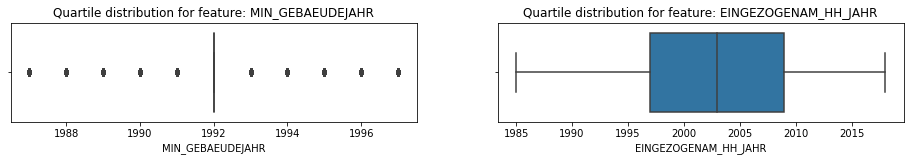

In [38]:
h.plot_boxplot(eda_azdias.data, numeric_feats,n_cols=2,  figsize = (16, 4))     

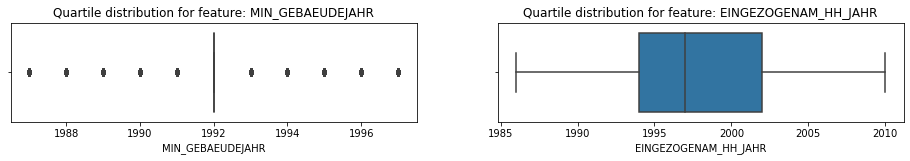

In [39]:
h.plot_boxplot(eda_customers.data, numeric_feats,n_cols=2,  figsize = (16, 4))     

#####  b. 分析类别类型数据的离群值

In [40]:
eda_azdias.feat_info.loc[eda_azdias.feat_info.type == 'categorical']

,type,unknown,n_nans,percent_of_nans,n_distinct,Q1,Q3,IQR
feat,,,,,,,,
AGER_TYP,categorical,"[-1,0]",NaN,NaN,NaN,NaN,NaN,NaN
ANREDE_KZ,categorical,"[-1,0]",0.0,0.00,2.0,1.0,2.0,1.0
CAMEO_DEUG_2015,categorical,"['-1','X']",3285.0,0.00,10.0,3.0,8.0,5.0
CAMEO_DEU_2015,categorical,['XX'],NaN,NaN,NaN,NaN,NaN,NaN
CJT_GESAMTTYP,categorical,[0],4276.0,0.01,7.0,2.0,5.0,3.0
D19_KONSUMTYP,categorical,[],163456.0,0.22,8.0,2.0,9.0,7.0
DSL_FLAG,categorical,[],0.0,0.00,2.0,1.0,1.0,0.0
FINANZTYP,categorical,[-1],0.0,0.00,6.0,2.0,6.0,4.0
GEBAEUDETYP,categorical,"[-1,0]",0.0,0.00,7.0,1.0,3.0,2.0


In [41]:
h.check_features(eda_azdias, 'categorical')      

AGER_TYP was eliminated already
ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  7.  5.  3. nan]
CAMEO_DEU_2015 was eliminated already
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
D19_KONSUMTYP [nan  9.  1.  4.  3.  6.  5.  2.]
DSL_FLAG [1. 0.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
HH_DELTA_FLAG [ 0. nan  1.]
KK_KUNDENTYP was eliminated already
KONSUMZELLE [ 1.  0. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB was eliminated already
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  8.  5.  6.  7. nan]
LP_STATUS_GROB was eliminated already
NATIONALITAET_KZ [ 1.  3.  2. nan]
OST_WEST_KZ [1 0]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
TITEL_KZ was eliminated already
UNGLEICHENN_FLAG [1. 0.]
VERS_TYP [ 2.  1. nan]
ZABEOTYP [5 3 4 1 6 2]
D19_KONSUMTYP_MAX [9 8 1 2 4 3]
VHA was eliminated already
VHN [ 4.  2. nan  1.  3.]
GEMEINDETY

In [42]:
# eda_azdias.feat_info.loc['CAMEO_DEU_2015']
eda_customers.feat_info.loc['D19_KONSUMTYP']

type               categorical
unknown                     []
n_nans                     926
percent_of_nans           0.01
n_distinct                   8
Q1                           2
Q3                           3
IQR                          1
Name: D19_KONSUMTYP, dtype: object

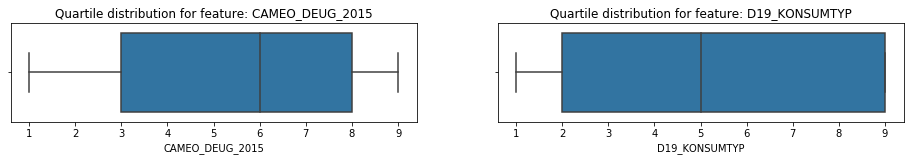

In [43]:
cat_feats  = ['CAMEO_DEUG_2015',  'D19_KONSUMTYP']
h.plot_boxplot(eda_azdias.data, cat_feats, n_cols=2 ,  figsize = (16, 4))     

In [44]:
h.plot_boxplot(eda_customers.data, cat_feats, n_cols=3 ,  figsize = (16, 4))     

<Figure size 1152x288 with 0 Axes>

####  Step  8:   空值估计

In [45]:
# 用中位数估计空值
imputer = Imputer(strategy='median')

eda_azdias.data_imputed = pd.DataFrame(imputer.fit_transform(eda_azdias.data), columns = eda_azdias.data.columns)
eda_customers.data_imputed = pd.DataFrame(imputer.fit_transform(eda_customers.data))

####  Step  9:   特征缩放

In [46]:
eda_azdias.data_scaled = StandardScaler().fit_transform(eda_azdias.data_imputed)    
eda_customers.data_scaled = StandardScaler().fit_transform(eda_customers.data_imputed)   

In [47]:
for x in (feats_todrop_comm, feats_duplicated, feats_wo_def):
    feats_todrop.extend(x)

pd.Series(feats_todrop).sort_values().to_csv('feats_dropped.csv', index=False)

## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

### 数据对比 Customers vs. Azdias 

 ####  对比包含有关消费者邮购活动的特征 (以D19_开头)
 D19: This data contains unique data regarding the mail-order activity of consumers, differentiated
 根据字典定义，以D19_开头的特征是包含有关消费者邮购活动的唯一数据。  

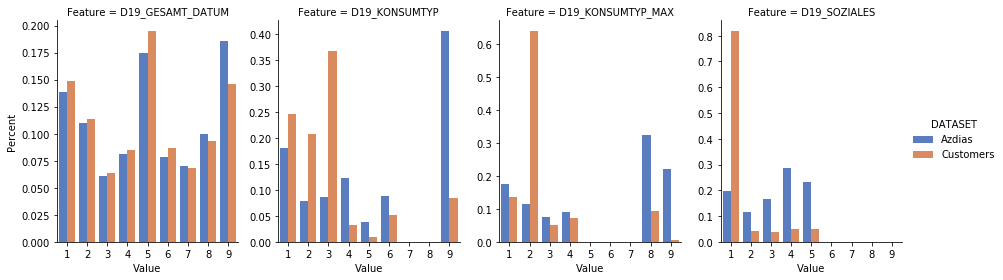

In [48]:
comm_feats = set(eda_customers.data.columns).intersection(set(eda_azdias.data.columns))
feats_D19 =set([x for x in comm_feats if x.startswith( 'D19_')])
feats_D19 = pd.Series(list(feats_D19)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_D19)

上图 的 D19 组特征对比显示:
 - D19_SOZIALES 的值 1 在Customers中显著高于Azdias， 虽然特征字典没有给出D19_SOZIALES的定义。但是可以猜到它表示的是一种商品，而值 1表示在过去一年中有多次购买 (Multibuyer 0-12 months).
 - D19_KONSUMTYP 的 值 2， 3 和 9 在两个数据集中差异很大。 它们分别表示 2: 多才多艺, 3: 美食家, 9 不活跃。其中 2，3 是Customers显著高于Azdias, 而 9 是显著低于Azdias.  表示目标客户是 美食家, 多才多艺,和活跃型.
 - D19_KONSUMTYP_MAX 的值 2 显著高于Azdias, 8 和 9 明显低于Azdias. 但字典没有给出 D19_KONSUMTYP_MAX 的定义. 

#### CAMEO_ 类特征对比 

 'CAMEO_DEUG_2015' 表示 “New German CAMEO Typology established together with Call Credit in late 2015”

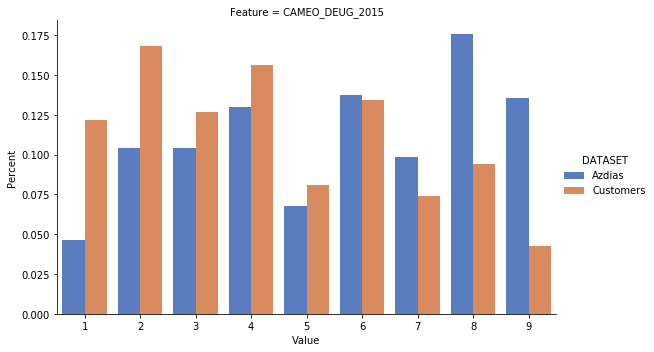

In [49]:
h.plot_feats_comparison(eda_azdias.data, eda_customers.data, ['CAMEO_DEUG_2015'], fig_height=5, fig_aspect=1.6)

 - CAMEO_DEUG_2015 的值 1, 2  Customers中明显高于Azdias，而 8 和 9 明显低于 Azdias。 表示目标客户是中上阶层人士。

####  对比包含有关消费者邮购活动的特征 (以CJT_开头)

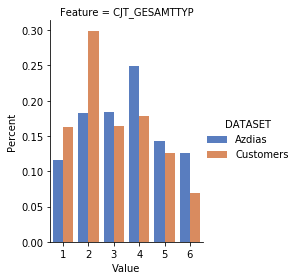

In [50]:
feats_CJT =set([x for x in eda_customers.data.columns if x.startswith( 'CJT_')])
feats_CJT = pd.Series(list(feats_CJT)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_CJT)

- CJT_GESAMTTYP :   customer journey typology.   值 2  Customers中明显高于Azdias， 表示目标客户是广告与消费传统主义.

### PCA 降维

total explained_variance:  0.9697653021637768
n_components:  200


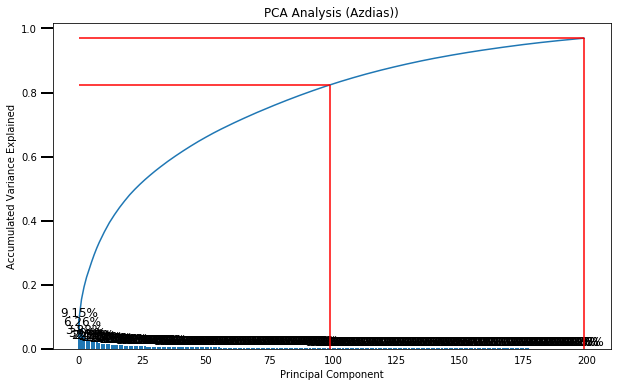

In [51]:
h.do_pca(eda_azdias, 200)

print(f'total explained_variance:  {eda_azdias.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_azdias.pca.n_components_)

h.scree_plot(eda_azdias)

total explained_variance:  0.9678405856492591
n_components:  200


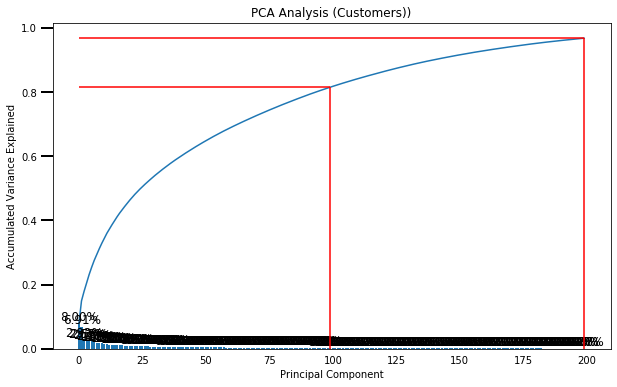

In [55]:
h.do_pca(eda_customers, 200)

print(f'total explained_variance:  {eda_customers.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_customers.pca.n_components_)

h.scree_plot(eda_customers)

### KMeans 聚类  

In [57]:
h.do_pca(eda_azdias, 100)
h.do_pca(eda_customers, 100)

Text(0.5, 1.0, 'SSE vs. K')

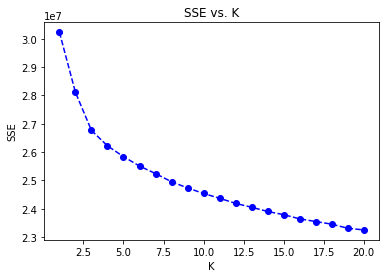

In [58]:
scores = []
centers = list(range(1,21))

for center in centers:
    _, score = h.get_kmeans_score(eda_customers.X_pca, center)
    scores.append(score)
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

#### 聚类比较  Global vs Customers 

In [59]:
model_c, score = h.get_kmeans_score(eda_customers.X_pca, 10)
print(score)
model_a, score = h.get_kmeans_score(eda_azdias.X_pca, 10)
print(score)

24536849.057
134210437.136


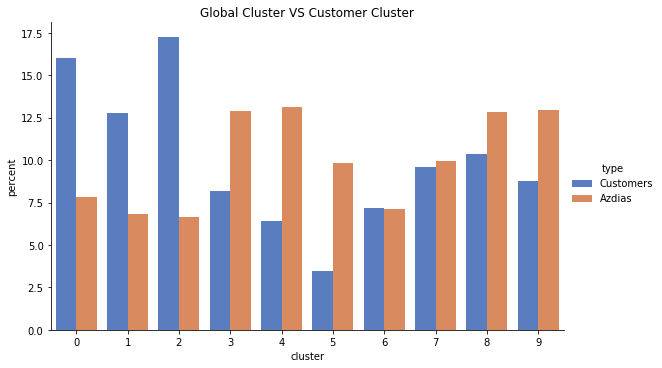

In [60]:
preds_c = model_c.predict(eda_customers.X_pca)
preds_a = model_a.predict(eda_azdias.X_pca)

counts_c, counts_a = h.plot_cluster_comparison(preds_c, preds_a)

In [61]:
comp_diff_s = (counts_c.percent - counts_a.percent).sort_values(ascending=False)
pd.DataFrame(
    {
        'cluster': comp_diff_s.index,
        'diff_pct': comp_diff_s.values
    }
)

,cluster,diff_pct
0,2,10.630522
1,0,8.208422
2,1,5.951305
3,6,0.077597
4,7,-0.332396
5,8,-2.519024
6,9,-4.217881
7,3,-4.712674
8,5,-6.348345
9,4,-6.737525


In [64]:
def list_component(eda, top_n_comps):
    """ Listing the top N and the bottom N features of a given component
    Args: 
        eda - EDA object instance        
        top_n_comps            
    Returns: None

    """    
    listing = pd.DataFrame({
                        'Features':list(eda.data.columns),
                        'Weights':eda.pca.components_[top_n_comps]}).sort_values('Weights', axis=0, ascending=False).values.tolist()

    return listing[:5]+['^^^HEAD','TAILvvv']+listing[-5:]  

In [66]:
list_component(eda_customers, 2)

[['FINANZ_SPARER', 0.214036594474099],
 ['PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE', 0.21257221158165077],
 ['FINANZ_ANLEGER', 0.18718221322392656],
 ['SEMIO_RAT', 0.16476414910106169],
 ['SEMIO_PFLICHT', 0.1583130069051247],
 '^^^HEAD',
 'TAILvvv',
 ['LP_LEBENSPHASE_GROB_SPLIT_AGE', -0.12808187358578474],
 ['KBA05_ALTER4', -0.13612328811114355],
 ['SEMIO_LUST', -0.1490001755171961],
 ['ALTERSKATEGORIE_GROB', -0.17971657359189208],
 ['FINANZ_VORSORGER', -0.1951622467214415]]

In [68]:
list_component(eda_customers, 0)

[['KBA13_ANTG3', 0.1667276693199897],
 ['PLZ8_ANTG3', 0.16560463462569222],
 ['KBA13_BAUMAX', 0.15823272632360175],
 ['KBA13_ANTG4', 0.15611069847166917],
 ['PLZ8_BAUMAX', 0.15484742960358353],
 '^^^HEAD',
 'TAILvvv',
 ['MOBI_RASTER', -0.14842349972494942],
 ['KBA13_AUTOQUOTE', -0.15265600171790736],
 ['KBA13_ANTG1', -0.1589878993278549],
 ['PLZ8_ANTG1', -0.15911288424959782],
 ['MOBI_REGIO', -0.1616410402000578]]

In [69]:
list_component(eda_customers, 1)

[['KBA13_HERST_BMW_BENZ', 0.15523993630300498],
 ['KBA13_SEG_OBEREMITTELKLASSE', 0.13346010409780423],
 ['KBA13_KMH_211', 0.13236176719933754],
 ['KBA05_KW3', 0.13209858666676458],
 ['KBA13_MERCEDES', 0.13111195055223598],
 '^^^HEAD',
 'TAILvvv',
 ['KBA13_SEG_KLEINST', -0.1115525504564058],
 ['KBA13_SEG_KLEINWAGEN', -0.12268906511385963],
 ['KBA13_KMH_140_210', -0.12745758105310215],
 ['KBA13_KW_0_60', -0.13592249994591143],
 ['KBA13_KMH_180', -0.139887822744439]]

## 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

### 加载数据

In [70]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_pickle ('..//data//mailout_train.p')    
mailout_train.shape

(42962, 367)

In [71]:
# feats_customers_excl = ['CUSTOMER_GROUP','ONLINE_PURCHASE' ,'PRODUCT_GROUP']
# mailout_train.drop(columns = feats_customers_excl, inplace =True)
positive_cnts = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]
total_cnts = mailout_train.shape[0]
 
print(f'The train set contains only {positive_cnts / total_cnts *100 :1.2f}% customers with positive response')

The train set contains only 1.24% customers with positive response


(array([113.,   0.,   0.,   0.,   0.,  16., 229.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.]),
 array([0.        , 0.0293837 , 0.05876739, 0.08815109, 0.11753478,
        0.14691848, 0.17630218, 0.20568587, 0.23506957, 0.26445327,
        0.29383696, 0.32322066, 0.35260435, 0.38198805, 0.41137175,
        0.44075544, 0.47013914, 0.49952283, 0.52890653, 0.55829023,
        0.58767392, 0.61705762, 0.64644131, 0.67582501, 0.70520871,
        0.7345924 , 0.7639761 , 0.7933598 , 0.82274349, 0.85212719,
        0.88151088, 0.91089458, 0.94027828, 0.96966197, 0.99904567]),
 <a list of 34 Patch objects>)

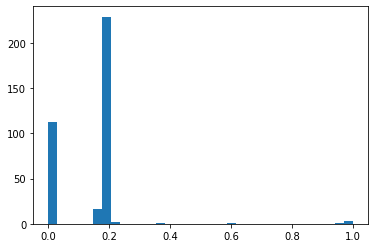

In [72]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

plt.hist(missing_per_column, bins=34)

### 数据预处理

In [73]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
feat_info.set_index('feat', inplace =True)

eda_mailout_train = eda.EDA(mailout_train, feat_info, label = 'mailout_train')
# eda_mailout_train.data

In [74]:
eda_mailout_train.data_pipeline()

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_train 
After cleaning, Number of columns is 262 in mailout_train 
Step 2: Convert missing and unknown values ...
Number of missing values in mailout_train:
Before converstion is 1809846
Ater converstion IS 1918834
Increase in missing values: 6.02 % 
Step 3: Delete the rows with more NaN values ...
Before cleaning, Number of rows is 262 in mailout_train 
After cleaning, Number of columns is 262 in mailout_train 
  8545 lines deleted!
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
   Re-encoding: EINGEFUEGT_AM ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
Step 6: Handling outliers ...
   Processing outliers for feature type: numeric
 Processing outliers for MIN_GEBAEUDEJAHR 

In [75]:
response = response.loc[mailout_train.index]
response.shape

(34417,)

### 模型选择

In [76]:
def build_roc_auc(model_dict, param_grid, X_train, y_train):
    '''
    Function for calculating auc and roc
    INPUT:
    stuff 
    OUTPUT:
    auc - returns auc as a float
    prints the roc auc score
    '''
    
    for k, clf in model_dict.items():
            grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=10)
            grid.fit(X_train, y_train)
            print(f'Model: {k},  Best ROC AUC score:  {grid.best_score_}')           


In [77]:
lrm = LogisticRegression(random_state=h.RANDOM_STATE)
bagm = BaggingClassifier()
lgbm = lgb.LGBMClassifier(random_state=h.RANDOM_STATE,application='binary')

model_dict = {
    'logistic regression': lrm,    
    'bagging': bagm,
    'lgbmclassifier': lgbm,
}

build_roc_auc(model_dict, {},eda_mailout_train.data_scaled, response)    

Model: logistic regression,  Best ROC AUC score:  0.7649884539215374
Model: bagging,  Best ROC AUC score:  0.6044008854724616
Model: lgbmclassifier,  Best ROC AUC score:  0.769817444714204


### LGB模型参数优化

In [78]:
# eda_mailout_train = pd.read_pickle ('../ArvatoPrj_200222.liso/eda_mailout_train.full.pkl')        
# response = pd.read_pickle ('../ArvatoPrj_200222.liso/response.pkl')        

train_data, test_data, train_targets, test_targets = train_test_split(
    eda_mailout_train.data_scaled, 
    response, 
    test_size=0.20, 
    shuffle=True,
    random_state=h.RANDOM_STATE)

train_data, test_data, train_targets, test_targets = pd.DataFrame(train_data), pd.DataFrame(test_data), pd.Series(train_targets), pd.Series(test_targets) 

In [79]:
print('Positive weight for the complete target: ', round(float(np.sum(response == 0)) / np.sum(response == 1), 3))
print('Positive weight for the train dataset:   ', round(float(np.sum(train_targets == 0)) / np.sum(train_targets == 1), 3))
print('Positive weight for the test dataset:    ', round(float(np.sum(test_targets == 0)) / np.sum(test_targets == 1), 3))
v_posWeight = 79.75

Positive weight for the complete target:  79.602
Positive weight for the train dataset:    80.943
Positive weight for the test dataset:     74.648


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.08s/trial, best loss: -0.7982559978093159]
Best ROC -0.798 params {'colsample_bytree': 0.7914251370847547, 'learning_rate': 0.00013525207008504797, 'min_data_in_leaf': 1150.0, 'min_sum_hessian_in_leaf': 0.0012492697133027963, 'num_leaves': 11.0, 'reg_alpha': 0.7338146729873141, 'reg_lambda': 0.3127222606297919}


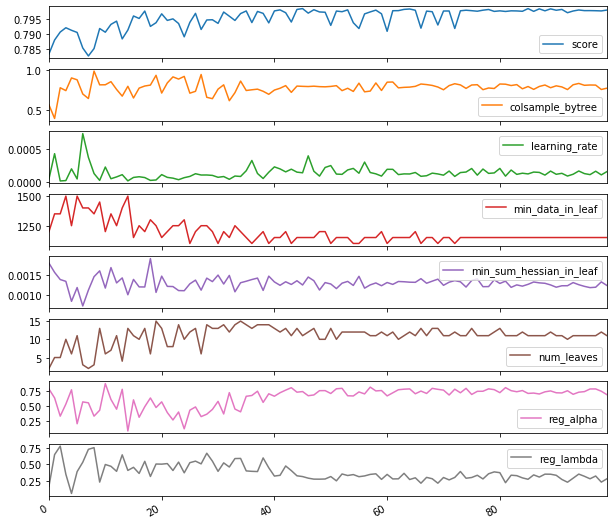

In [80]:
def_params={
        'learning_rate':  {'hpf' :  hp.loguniform('learning_rate', np.log(0.00001), np.log(0.0075)),'dtype' : 'float'},           
        'num_leaves' :    {'hpf' : hp.quniform('num_leaves', 1, 15, 1),'dtype' : 'int'},     
        'min_data_in_leaf' : {'hpf' : hp.quniform('min_data_in_leaf', 1000, 1500, 50),'dtype' : 'int'},     
        'min_sum_hessian_in_leaf':  {'hpf' : hp.uniform('min_sum_hessian_in_leaf', 0.0005, 0.002),'dtype' : 'float'},               
        'colsample_bytree': {'hpf': hp.uniform('colsample_bytree', 0.2, 1.),'dtype' : 'float'},        
        'reg_alpha': {'hpf': hp.uniform('reg_alpha', 0,1.0),'dtype' : 'float'}, 
        'reg_lambda': {'hpf': hp.uniform('reg_lambda', 0, 1.0),'dtype' : 'float'}, 
        # //////////////////////////////////////////////////////    
#             'n_estimators' :  {'hpf' : hp.quniform('n_estimators', 1000, 2000, 100),'dtype' : 'int'},            
#         'max_bin': {'hpf' : hp.quniform('max_bin', 10,100, 10) ,'dtype' : 'int'},            
#             'max_depth':   {'hpf': hp.quniform('max_depth', 3, 90, 5),'dtype' : 'int'},         

}

n_iter = 100
cv = 10

best, trials, objective = t.search_hyperparameter(def_params, n_iter, cv ,train_data, train_targets)

model = t.build_model(best, def_params)

model.fit(train_data,train_targets)

t.evaluate_model(model, objective, best, test_data, test_targets)

sa_results_df = t.plot_result(trials.trials)

### Top 15 most important features of the model

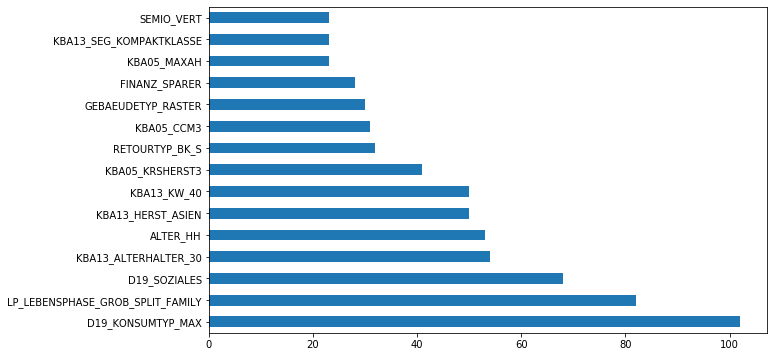

In [81]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=eda_mailout_train.data.columns)
feat_importances.nlargest(15).plot(kind='barh',  figsize=(10, 6))
plt.show()

## Part 3:Kaggle比赛

你已经搭建了一个用于预测人们有多大程度上会回应邮购活动的模型，是时候到Kaggle上检验一下这个模型了。如果你点击这个 [链接](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140)，你会进入到比赛界面（如果你已经有一个Kaggle账户的话）如果你表现突出的话，你将有机会收到Arvato或Bertelsmann的人力资源管理的经理的面试邀约！

你比赛用提交的文件格式为CSV，该文件含2列。第一列是"LNR"，是"TEST"部分每个顾客的ID。第二列是"RESPONSE"表示此人有多大程度上会参加该活动，可以是某种度量，不一定是概率。你应该在第2部分已经发现了，该数据集存在一个巨大的输出类不平衡的问题，也就是说大部分人都不会参加该邮购活动。因此，预测目标人群的分类并使用准确率来衡量不是一个合适的性能评估方法。相反地，该项竞赛使用AUC衡量模型的性能。"RESPONSE"列的绝对值并不重要：仅仅表示高的取值可能吸引到更多的实际参与者，即ROC曲线的前端曲线比较平缓。

In [82]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_pickle ('..//data//mailout_test.p')    
mailout_test.shape

(42833, 366)

In [83]:
eda_mailout_test = eda.EDA(mailout_test, feat_info, label = 'mailout_test')

In [84]:
LNR = mailout_test.LNR.copy()
LNR.shape

(42833,)

In [85]:
eda_mailout_test.data_pipeline(clean_rows = False)

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_test 
After cleaning, Number of columns is 262 in mailout_test 
Step 2: Convert missing and unknown values ...
Number of missing values in mailout_test:
Before converstion is 1783358
Ater converstion IS 1891132
Increase in missing values: 6.04 % 
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
   Re-encoding: EINGEFUEGT_AM ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
Step 6: Handling outliers ...
   Processing outliers for feature type: numeric
 Processing outliers for MIN_GEBAEUDEJAHR  ...
 Processing outliers for EINGEZOGENAM_HH_JAHR  ...
   Processing outliers for feature type: categorical
 Processing outliers for D19_KONSUMTYP  ...
Step 7: Estimating NaN values with me

In [86]:
mailout_test.shape

(42833, 277)

In [87]:
preds_test = model.predict_proba(eda_mailout_test.data_scaled)[:,1]
preds_test

array([0.50214384, 0.50259025, 0.49516411, ..., 0.50005349, 0.50165973,
       0.5005017 ])

In [88]:
preds_test = pd.concat([LNR, pd.Series(preds_test)], axis = 1)
preds_test.rename(columns={0:'RESPONSE'}, inplace= True)
preds_test

,LNR,RESPONSE
0,1754,0.502144
1,1770,0.502590
2,1465,0.495164
3,1470,0.495405
4,1478,0.495883
...,...,...
42828,67615,0.493846
42829,67938,0.494484
42830,67942,0.500053
42831,67949,0.501660


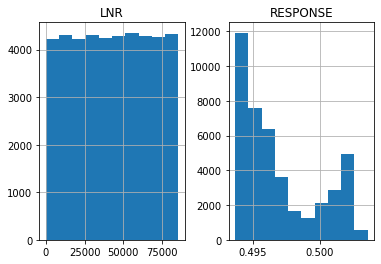

In [89]:
preds_test.hist()
preds_test.to_csv('MAILOUT_TEST.csv')

In [90]:
def save_runs(run_name, model, model_type, space, trials, best, n_iter, preds_test):
    run_dic = {
        'run_name': run_name,
        'model' : model,
        'model_type': model_type,
        'space': space,
        'trails': trials,
        'best':  best,
        'n_iters':  n_iter,
        'preds_test': preds_test
    }
    
    file = open( run_name+'.pkl',  'wb')
    pickle.dump(run_dic, file)

In [91]:
import datetime
model_type =  'lgb.LGBMClassifier'    
# save_runs('run_'+model_type+f'_iters_{str(n_iter)}_'+datetime.datetime.now().strftime('%Y.%m.%d'), model,model_type, def_params, trials, best, n_iter, preds_test)    